<a href="https://colab.research.google.com/github/ArkanEmre/AI-Based-Retail-Product-Identification/blob/master/ai_based_retail_product_identification_own_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Preprocessing


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tarfile
from google.colab import drive

tar = tarfile.open("/content/drive/My Drive/Colab Notebooks/datasets/grozi120.tar.gz", "r")
tar.extractall('/content')

In [0]:
import os
import pandas as pd
dataset_path = '/content/grozi120'
new_path = '/content/grozi120/processed'

In [0]:
if not os.path.exists(os.path.join(new_path, 'inVitro')):
  os.makedirs(os.path.join(new_path, 'inVitro'))

labels = {}
with open(os.path.join(dataset_path, 'UPC_index.txt'), 'r') as f:
  lines = [line.rstrip() for line in f.readlines()[1:] if line != '\n']
  for i in range(0, len(lines)-2, 3):
    labels[int(lines[i])] = [lines[i+1], lines[i+2]]

dataset = {
  'file_name': [], 
  'label': []
}
for product in os.listdir(os.path.join(dataset_path, 'inVitro')):
  for product_file in os.listdir(os.path.join(dataset_path, 'inVitro', product, 'web', 'JPEG')):
    if product_file == 'Thumbs.db':
      continue
    dataset['file_name'].append(os.path.join(dataset_path, 'inVitro', product, 'web', 'JPEG', product_file))
    dataset['label'].append(labels[int(product)][1])

df = pd.DataFrame(dataset, columns=['file_name', 'label'])

In [0]:
import csv
from shutil import copyfile

if not os.path.exists(os.path.join(new_path, 'inSitu')):
    os.makedirs(os.path.join(new_path, 'inSitu'))

evaluation_dataset = {
  'file_name': [], 
  'label': []
}

for product in os.listdir(os.path.join(dataset_path, 'inSitu')):
    for product_file in os.listdir(os.path.join(dataset_path, 'inSitu', product, 'video')):
        if product_file == 'Thumbs.db':
            continue
        evaluation_dataset['file_name'].append(os.path.join(dataset_path, 'inSitu', product, 'video', product_file))
        evaluation_dataset['label'].append(labels[int(product)][1])

evaluation_df = pd.DataFrame(evaluation_dataset, columns=['file_name', 'label'])

with open(os.path.join(new_path, 'inSitu', 'evaluation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(evaluation_dataset['file_name'], evaluation_dataset['label']):
        split = file_name.split('/')
        dataset_writer.writerow([os.path.join(new_path, 'inSitu', '{}_{}'.format(split[-3], split[-1])), label])
        copyfile(file_name, os.path.join(new_path, 'inSitu','{}_{}'.format(split[-3], split[-1])))

In [0]:
from sklearn.model_selection import train_test_split

train_filenames, validation_filenames, train_labels, validation_labels = train_test_split(df['file_name'], df['label'], train_size=0.75, random_state=42, stratify=df['label'])

if not os.path.exists(os.path.join(new_path, 'inVitro', 'train')):
    os.makedirs(os.path.join(new_path, 'inVitro', 'train'))
with open(os.path.join(new_path, 'inVitro', 'train.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(train_filenames, train_labels):
        split = file_name.split('/')
        dataset_writer.writerow([os.path.join(new_path, 'inVitro', 'train','{}_{}'.format(split[-4], split[-1])), label])
        copyfile(file_name, os.path.join(new_path, 'inVitro', 'train','{}_{}'.format(split[-4], split[-1])))

if not os.path.exists(os.path.join(new_path, 'inVitro', 'validation')):
    os.makedirs(os.path.join(new_path, 'inVitro', 'validation'))
with open(os.path.join(new_path, 'inVitro', 'validation.csv'), mode='w') as dataset_file:
    dataset_writer = csv.writer(dataset_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    dataset_writer.writerow(['file_name', 'label'])
    for file_name, label in zip(validation_filenames, validation_labels):
        split = file_name.split('/')
        dataset_writer.writerow([os.path.join(new_path, 'inVitro', 'validation','{}_{}'.format(split[-4], split[-1])), label])
        copyfile(file_name, os.path.join(new_path, 'inVitro', 'validation','{}_{}'.format(split[-4], split[-1])))

tensorflow addons nightly must be installed, otherwise 
```tensorflow_addons.image.rotate``` will not work

In [0]:
pip install tfa-nightly

     |████████████████████████████████| 1.1MB 12.3MB/s 


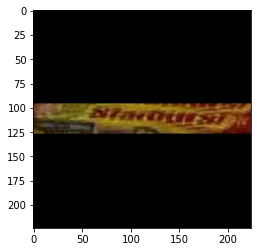

[b'Starburst Original Fruit']


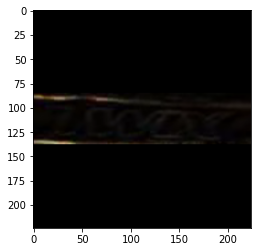

[b'Twix Cookie Bar']


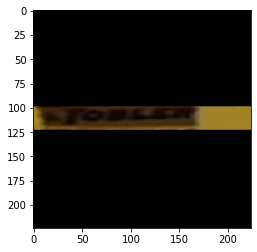

[b'TOBLERONE MILK CHOCOLATE']


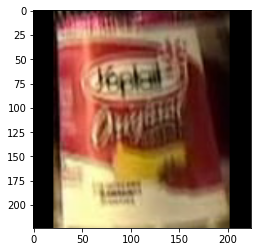

[b'Yoplait Yogurt Original Strawberry Banana 99% Fat Free S70']


In [0]:
import tensorflow as tf
import random
import matplotlib.pyplot as plt

from numpy import argmax
import math
from math import radians
import numpy as np

from tensorflow.io import read_file, decode_jpeg, decode_png
from tensorflow.image import convert_image_dtype, resize_with_pad, random_brightness, random_contrast, random_hue, random_saturation, ResizeMethod
from tensorflow_addons.image import rotate
from tensorflow.data.experimental import AUTOTUNE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


train_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'train.csv'))
validation_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'validation.csv'))
evaluation_df = pd.read_csv(os.path.join(new_path, 'inSitu', 'evaluation.csv'))

train_filenames = tf.constant(train_df['file_name'])
train_labels = tf.constant(train_df['label'])

validation_filenames = tf.constant(validation_df['file_name'])
validation_labels = tf.constant(validation_df['label'])

evaluation_filenames = tf.constant(evaluation_df['file_name'])
evaluation_labels = tf.constant(evaluation_df['label'])

label_encoder = LabelEncoder()

train_labels_integer_encoded = label_encoder.fit_transform(train_labels)
validation_labels_integer_encoded = label_encoder.fit_transform(validation_labels)
evaluation_labels_integer_encoded = label_encoder.fit_transform(evaluation_labels)

# binary encode
label_onehot_encoder = OneHotEncoder(sparse=False)

train_labels_integer_encoded = train_labels_integer_encoded.reshape(len(train_labels_integer_encoded), 1)
train_labels_onehot_encoded = label_onehot_encoder.fit_transform(train_labels_integer_encoded)

validation_labels_integer_encoded = validation_labels_integer_encoded.reshape(len(validation_labels_integer_encoded), 1)
validation_labels_onehot_encoded = label_onehot_encoder.fit_transform(validation_labels_integer_encoded)

evaluation_labels_integer_encoded = evaluation_labels_integer_encoded.reshape(len(evaluation_labels_integer_encoded), 1)
evaluation_labels_onehot_encoded = label_onehot_encoder.fit_transform(evaluation_labels_integer_encoded)

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels_onehot_encoded))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_filenames, validation_labels_onehot_encoded))
evaluation_dataset = tf.data.Dataset.from_tensor_slices((evaluation_filenames, evaluation_labels_onehot_encoded))

NUM_TRAIN_EXAMPLES = train_df.size

NUM_VAL_EXAMPLES = validation_df.size

NUM_EVAL_EXAMPLES = evaluation_df.size

IMG_SIZE = 224
BATCH_SIZE = 16

def crop_center_and_resize(img, size):
    s = tf.shape(img)
    w, h = s[0], s[1]
    c = tf.minimum(w, h)
    w_start = (w - c) // 2
    h_start = (h - c) // 2
    center = img[w_start:w_start + c, h_start:h_start + c]
    return tf.image.resize(center, [size, size])

def preprocess_train_images(image,label):
  image = read_file(image)
  image = decode_jpeg(image, channels=3)
  image = convert_image_dtype(image, dtype=tf.float64, saturate=False)
  image = resize_with_pad(image, IMG_SIZE, IMG_SIZE, method=ResizeMethod.BILINEAR, antialias=True)
  #image = crop_center_and_resize(image, IMG_SIZE)

  rotation_radian = tf.random.uniform(shape=[], minval=-90, maxval=90, dtype=tf.float32) * np.pi / 180
  image = rotate(image, rotation_radian, interpolation='BILINEAR')

  image = random_brightness(image, 0.1)
  image = random_contrast(image, 0.4, 1)
  image = random_hue(image, 0.1)
  #image = random_saturation(image, 2, 5)
  
  return image,label

def preprocess_validation_images(image,label):
  image = read_file(image)
  image = decode_jpeg(image, channels=3)
  image = convert_image_dtype(image, dtype=tf.float64, saturate=False)
  image = resize_with_pad(image, IMG_SIZE, IMG_SIZE, method=ResizeMethod.BILINEAR, antialias=True)
  return image,label

def preprocess_evaluation_images(image,label):
  image = read_file(image)
  image = decode_png(image, channels=3)
  image = convert_image_dtype(image, dtype=tf.float64, saturate=False)
  image = resize_with_pad(image, IMG_SIZE, IMG_SIZE, method=ResizeMethod.BILINEAR, antialias=True)
  return image,label

train_batches = train_dataset.shuffle(NUM_TRAIN_EXAMPLES//4).map(preprocess_train_images, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).repeat()
validation_batches = validation_dataset.shuffle(NUM_VAL_EXAMPLES//4).map(preprocess_validation_images, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).repeat()
evaluation_batches = evaluation_dataset.shuffle(NUM_EVAL_EXAMPLES//4).map(preprocess_evaluation_images, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).repeat()

batch = evaluation_batches.skip(2).take(2)
for sample in batch:
  for i in range(0, 2):
    plt.imshow(sample[0].numpy()[i])
    plt.show()
    # invert first example
    inverted = label_encoder.inverse_transform([argmax(sample[1].numpy()[i])])
    print(inverted)

Found 507 validated image filenames belonging to 120 classes.
Found 169 validated image filenames belonging to 120 classes.
Found 11194 validated image filenames belonging to 120 classes.


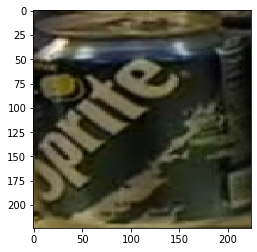

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL
from keras_preprocessing.image import ImageDataGenerator


train_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'train.csv'))
validation_df = pd.read_csv(os.path.join(new_path, 'inVitro', 'validation.csv'))
evaluation_df = pd.read_csv(os.path.join(new_path, 'inSitu', 'evaluation.csv'))

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.2,1.5],
    rescale=1. / 255)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

evaluation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, directory=os.path.join(new_path, 'inVitro', 'train'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow_from_dataframe(dataframe=validation_df, directory=os.path.join(new_path, 'inVitro', 'validation'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

evaluation_generator  = evaluation_datagen.flow_from_dataframe(dataframe=evaluation_df, directory=os.path.join(new_path, 'inSitu'), x_col="file_name", y_col="label", class_mode="categorical", target_size=(IMG_SIZE,IMG_SIZE), batch_size=BATCH_SIZE)

x,y = evaluation_generator.next()
for i in range(0,1):
    image = x[i]
    label = y[i]
    plt.imshow(image)
    plt.show()
    print (label)

## Defining data augmentations

In [0]:
train_generator.class_indices

NameError: ignored

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                                         include_top=False,
                                         weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_609 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_609 (BatchN (None, 111, 111, 32) 96          conv2d_609[0][0]                 
__________________________________________________________________________________________________
activation_609 (Activation)     (None, 111, 111, 32) 0           batch_normalization_609[0][0]    
________________________________________________________________________________

In [0]:
global_max_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(120, activation='softmax')

In [0]:
model = tf.keras.Sequential([
  base_model,
  global_max_layer,
  prediction_layer
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_max_pooling2d_3 (Glob (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               184440    
Total params: 54,521,176
Trainable params: 184,440
Non-trainable params: 54,336,736
_________________________________________________________________


In [0]:
import math
NUM_EPOCHS = 250

STEPS_PER_EPOCH = math.ceil(NUM_TRAIN_EXAMPLES / BATCH_SIZE)
VAL_STEPS_PER_EPOCH = math.ceil(NUM_VAL_EXAMPLES / BATCH_SIZE)

history = model.fit(train_batches, epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=validation_batches, validation_steps=VAL_STEPS_PER_EPOCH)

Epoch 1/250
64/64 [==============================] - 9s 141ms/step - loss: 3.9611 - accuracy: 0.8402 - val_loss: 4.1053 - val_accuracy: 0.7101
Epoch 2/250
64/64 [==============================] - 9s 139ms/step - loss: 3.9611 - accuracy: 0.8402 - val_loss: 4.1082 - val_accuracy: 0.7101
Epoch 3/250
64/64 [==============================] - 9s 142ms/step - loss: 3.9610 - accuracy: 0.8402 - val_loss: 4.1012 - val_accuracy: 0.7101
Epoch 4/250
64/64 [==============================] - 9s 141ms/step - loss: 3.9613 - accuracy: 0.8402 - val_loss: 4.0978 - val_accuracy: 0.7160
Epoch 5/250
64/64 [==============================] - 9s 141ms/step - loss: 3.9611 - accuracy: 0.8402 - val_loss: 4.0995 - val_accuracy: 0.7219
Epoch 6/250
64/64 [==============================] - 9s 144ms/step - loss: 3.9610 - accuracy: 0.8402 - val_loss: 4.0994 - val_accuracy: 0.7219
Epoch 7/250
64/64 [==============================] - 9s 142ms/step - loss: 3.9616 - accuracy: 0.8393 - val_loss: 4.1046 - val_accuracy: 0.7101

In [0]:
EVAL_STEPS_PER_EPOCH = math.ceil(NUM_EVAL_EXAMPLES / BATCH_SIZE)

model.evaluate(evaluation_batches, batch_size=BATCH_SIZE, verbose=1, steps=EVAL_STEPS_PER_EPOCH)

1400/1400 [==============================] - 136s 97ms/step - loss: 4.5114 - accuracy: 0.3051


[4.511435508728027, 0.30507415533065796]

In [0]:
import datetime

model_path = '/content/drive/My Drive/Colab Notebooks/models/grozi120/InceptionResNetV2_imagenet_{}'.format(datetime.datetime.now().strftime("%d_%m_%y_%H_%M_%S"))
model.save_weights(model_path)

In [0]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('/content/drive/My Drive/Colab Notebooks/datasets/processed/118_video40.png', target_size=(IMG_SIZE, IMG_SIZE))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

p = model.predict(x)
inverted = label_encoder.inverse_transform([argmax(p)])
print(inverted)

[b'LIFESTYLES ULTRA SENSITIVE']
